<a href="https://colab.research.google.com/github/YueShen220/proj-vis-eff/blob/main/final_model_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Using Tensorflow framework as backend
import os
import tables
import warnings
import cv2
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
from keras import models, layers, optimizers
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

% matplotlib inline
style.use('seaborn-whitegrid')
warnings.filterwarnings(action='once')

In [3]:
# Helper functions to process image data to NumPy arrays of size (224, 224, 3)
# and with backsubtraction and binary thresholding

def process_data(X_data, y_data, rgb):
    X_data = np.array(X_data, dtype = 'float32')
    if rgb:
        pass
    else:
        X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data

def walk_file_tree(relative_path):
    X_data = []
    y_data = [] 
    for directory, subdirectories, files in os.walk(relative_path):
        for file in files:
            if not file.startswith('.'):
                path = os.path.join(directory, file)
                gesture_name = gestures_index[file[9:11]]
                y_data.append(gesture_name)

                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.flip(img, 1)
                if img is not None:
                  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (41, 41), 0)  #tuple indicates blur value
                ret, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                thresh = cv2.resize(thresh, (224, 224))
                thresh = np.array(thresh)
                X_data.append(thresh)

            else:
                continue

    X_data, y_data = process_data(X_data, y_data, False)
    return X_data, y_data

## Load and process Kaggle data

In [4]:
# Mount on Google Drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Unzip the compressed folder on drive
!unzip /content/drive/MyDrive/archive.zip > /dev/null
!ls /content/leapGestRecog

00  01	02  03	04  05	06  07	08  09


In [6]:
# Gesture map
gestures_index = {'01': 1,   #Palm
                  '02': 2,   #L
                  '03': 3,   #Fist
                  '04': 4,   #Fist moved
                  '05': 5,   #Thumb
                  '06': 6,   #Index
                  '07': 7,   #Okay
                  '08': 8,   #Palm moved
                  '09': 9,   #C
                  '10': 10   #Down
                }

In [7]:
# Preprocess the image dataset
root_dir = '/content/leapGestRecog'
X_data, y_data = walk_file_tree(root_dir)

## Test

(20000, 224, 224, 3)
(20000, 11)


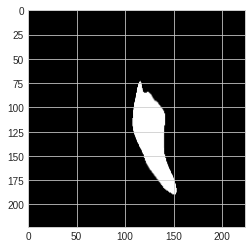

In [8]:
# Test and visualize the data
print(X_data.shape)
print(y_data.shape)
plt.imshow(X_data[19999])

## Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

## Save and load the the X, y data 

In [ ]:
hdf5_file = tables.open_file('train_test_split.h5', mode='w')
hdf5_file.create_array(hdf5_file.root,'X_train', obj=X_train)
hdf5_file.create_array(hdf5_file.root,'y_train', obj=y_train)
hdf5_file.create_array(hdf5_file.root,'X_test', obj=X_test)
hdf5_file.create_array(hdf5_file.root,'y_test', obj=y_test)
hdf5_file.close()

In [5]:
hdf5_file = tables.open_file('train_test_split.h5', mode='r')
X_train = np.array(hdf5_file.root.X_train)
y_train = np.array(hdf5_file.root.y_train)
X_test = np.array(hdf5_file.root.X_test)
y_test = np.array(hdf5_file.root.y_test)
hdf5_file.close()

## Build the VGG Model

In [9]:
file_path = '/content/drive/MyDrive/VGG_model.h5'
model_checkpoint = ModelCheckpoint(filepath=file_path, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

In [10]:
# Load VGG16
# Get back the convolutional part of a VGG network trained on ImageNet

imageSize = 224
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()

base_model = model1  # Topless
# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

predictions = Dense(11, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Train top layer
for layer in base_model.layers:
    layer.trainable = False

model.summary()


58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# Model training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_train, y_train), verbose=1,
          callbacks=[early_stopping, model_checkpoint])


# The following is NOT NEEDED, will not increase the model performance

# Data augmentation
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=45.,
#     width_shift_range=0.3,
#     height_shift_range=0.3,
#     horizontal_flip=True)

# datagen.fit(X_train)

# Fits the model on batches with real-time data augmentation:
# model.fit(datagen.flow(X_train, y_train, batch_size=32),
#           steps_per_epoch=len(X_train)/32, epochs=150, validation_data=(X_test, y_test))

Epoch 1/200
250/250 [==============================] - 8089s 32s/step - loss: 1.1298 - accuracy: 0.6189 - val_loss: 0.0025 - val_accuracy: 0.9994
Epoch 2/200
250/250 [==============================] - 8024s 32s/step - loss: 0.0171 - accuracy: 0.9957 - val_loss: 0.0090 - val_accuracy: 0.9977
Epoch 3/200
250/250 [==============================] - 8001s 32s/step - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.0038 - val_accuracy: 0.9990
Epoch 4/200
250/250 [==============================] - 8016s 32s/step - loss: 0.0298 - accuracy: 0.9912 - val_loss: 0.0026 - val_accuracy: 0.9991
Epoch 5/200
250/250 [==============================] - 8019s 32s/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0050 - val_accuracy: 0.9985
Epoch 6/200
250/250 [==============================] - 7743s 31s/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0337 - val_accuracy: 0.9923
Epoch 7/200
250/250 [==============================] - 8027s 32s/step - loss: 0.0289 - accuracy: 0.9938 - val_loss: 1.1738e-

## Save and load the model

In [ ]:
# Save the model to an hdf5 file
model.save('VGG_model.h5')

In [69]:
# Save the model to a pickle file
import pickle
f = open('/content/drive/MyDrive/VGG16_model_only_weights.pkl', 'wb')
pickle.dump(loaded_model.get_weights(), f)
f.close()

In [11]:
# Load the model from drive
from keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/VGG_model.h5')

## Evaluate VGG16 cross-validated model with classification metrics

In [18]:
def get_classification_metrics(X_test, y_test):
    pred = loaded_model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(confusion_matrix(y_true, pred))
    print('\n')
    print(classification_report(y_true, pred))

In [19]:
get_classification_metrics(X_data, y_data)

[[2000    0    0    0    0    0    0    0    0    0]
 [   0 2000    0    0    0    0    0    0    0    0]
 [   0    0 2000    0    0    0    0    0    0    0]
 [   0    0    0 2000    0    0    0    0    0    0]
 [   0    0    0    0 2000    0    0    0    0    0]
 [   0    0    0    0    0 2000    0    0    0    0]
 [   0    0    0    0    0    0 2000    0    0    0]
 [   0    0    0    0    0    0    0 2000    0    0]
 [   0    0    0    0    0    0    0    0 2000    0]
 [   0    0    0    0    1    0    0    0    0 1999]]


              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2000
           2       1.00      1.00      1.00      2000
           3       1.00      1.00      1.00      2000
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00      2000
           6       1.00      1.00      1.00      2000
           7       1.00      1.00      1.00      2000
           8       1.00      1.00 

## Predict gesture on a single RGB image

In [42]:
gesture_names = {1: 'Palm',
                 2: 'L',
                 3: 'Fist',
                 4: 'Fist moved',
                 5: 'Thumb',
                 6: 'Index',
                 7: 'Okay',
                 8: 'Palm moved',
                 9: 'C',
                 10: 'Down'}

def predict_rgb_image_vgg(image):
    image = np.array(image, dtype='float32')
    image /= 255
    pred_array = loaded_model.predict(image)
    print(f'pred_array: {pred_array}')
    result = gesture_names[np.argmax(pred_array)]
    print(f'Result: {result}')
    print(max(pred_array[0]))
    score = float("%0.2f" % (max(pred_array[0]) * 100))
    print(result)
    return result, score

def predict_rgb_image(path):

    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.flip(img, 1)
    if img is not None:
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (41, 41), 0)  #tuple indicates blur value
    ret, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    target = np.stack((thresh,) * 3, axis=-1)
    target = cv2.resize(target, (224, 224))
    target = target.reshape(1, 224, 224, 3)
    prediction, score = predict_rgb_image_vgg(target)

    print(f'Result: {prediction}, Score: {score}')
    return prediction, score

In [63]:
predict_rgb_image('/content/drive/MyDrive/test2.jpg')

pred_array: [[8.0924985e-17 1.0903999e-14 5.1684968e-15 3.5544319e-13 2.5051532e-12
  6.1026024e-16 5.6379221e-14 1.0000000e+00 9.9604333e-18 1.7662450e-14
  9.2193226e-16]]
Result: Okay
1.0
Okay
Result: Okay, Score: 100.0


('Okay', 100.0)